# Extract Köppen-Geiger Climate Composition per NUTS-2 Region

In [3]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# STEP 1: Load the NUTS-2 GeoJSON (High Resolution)

In [4]:
import requests
import geopandas as gpd

# ----------------------------------------------------------------------------
# Download NUTS-2 GeoJSON directly from Eurostat GISCO
# ----------------------------------------------------------------------------

# Construct the URL using the GISCO API pattern
# Pattern: https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_{SCALE}_{YEAR}_{PROJECTION}_LEVL_{LEVEL}.geojson

year = "2024"
scale = "03M"  # 1:3 Million (high resolution)
projection = "3035"  # EPSG:3035 (ETRS89-extended / LAEA Europe)
level = "2"  # NUTS level 2

url = f"https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_{scale}_{year}_{projection}_LEVL_{level}.geojson"

print(f"Downloading from:\n{url}\n")

# Download the file
response = requests.get(url)

# Check if download was successful
if response.status_code == 200:
    # Save to local file
    output_filename = f"NUTS_RG_{scale}_{year}_{projection}_LEVL_{level}.geojson"
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"✓ Download successful: {output_filename}")
    print(f"  File size: {len(response.content) / (1024*1024):.2f} MB")

    # Load directly into geopandas (optional: skip saving to disk)
    nuts_2 = gpd.read_file(output_filename)
    print(f"✓ Loaded {len(nuts_2)} NUTS-2 regions into GeoDataFrame")
    print(f"  CRS: {nuts_2.crs}")

else:
    print(f"✗ Download failed with status code: {response.status_code}")
    print(f"  Error: {response.text}")

https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_03M_2024_3035_LEVL_2.geojson

✓ Download successful: NUTS_RG_03M_2024_3035_LEVL_2.geojson
  File size: 3.34 MB
✓ Loaded 299 NUTS-2 regions into GeoDataFrame
  CRS: EPSG:3035


# STEP 2: Load the Köppen-Geiger Raster and Check CRS

In [5]:
koppen_raster_path = "koppen_geiger_0p00833333.tif"  # Your file

with rasterio.open(koppen_raster_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster bounds: {src.bounds}")
    print(f"Raster shape: {src.shape}")
    raster_crs = src.crs

RasterioIOError: koppen_geiger_0p00833333.tif: No such file or directory

# STEP 3: Reproject NUTS-2 to Match Raster CRS

In [ ]:
if nuts_2.crs != raster_crs:
    print(f"Reprojecting NUTS-2 from {nuts_2.crs} to {raster_crs}...")
    nuts_2 = nuts_2.to_crs(raster_crs)
    print("Reprojection complete.")

Reprojecting NUTS-2 from EPSG:3035 to EPSG:4326...
Reprojection complete.


# STEP 4: Run CATEGORICAL Zonal Statistics

In [ ]:
print("Running zonal statistics (this may take 5-10 minutes for all of Europe)...")

stats = zonal_stats(
    nuts_2,
    koppen_raster_path,
    categorical=True,      # KEY: Returns counts per unique pixel value
    nodata=0,              # Treat 0 as "no data" (ocean/missing)
    all_touched=False      # Only count pixels whose CENTER is inside the polygon
)

print("Zonal statistics complete.")

Running zonal statistics (this may take 5-10 minutes for all of Europe)...
Zonal statistics complete.


# STEP 5: Convert Results to DataFrame and Normalize

In [ ]:
climate_df = pd.DataFrame(stats)

# Fill NaN with 0 (if a region has no pixels of a certain climate, count = 0)
climate_df = climate_df.fillna(0)

# Calculate total pixels per region
climate_df['total_pixels'] = climate_df.sum(axis=1)

# Normalize to percentages (0.0 to 1.0)
for col in climate_df.columns:
    # Check if column is a number (climate class) and not 'total_pixels'
    if col != 'total_pixels' and isinstance(col, (int, float)):
        climate_df[f'pct_class_{col}'] = (
            climate_df[col] / climate_df['total_pixels']
        )

# Keep only the percentage columns
pct_cols = [c for c in climate_df.columns if str(c).startswith('pct_')]
climate_pct = climate_df[pct_cols].copy()

print(f"✓ Created {len(pct_cols)} climate percentage features")
print(f"\nSample columns: {pct_cols[:5]}")

✓ Created 20 climate percentage features

Sample columns: ['pct_class_7', 'pct_class_8', 'pct_class_9', 'pct_class_14', 'pct_class_15']


# STEP 6: Map Numeric Codes to Köppen Class Names

In [ ]:
koppen_legend = {
    1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk',
    8: 'Csa', 9: 'Csb', 10: 'Csc', 11: 'Cwa', 12: 'Cwb', 13: 'Cwc',
    14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc',
    20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa',
    26: 'Dfb', 27: 'Dfc', 28: 'Dfd', 29: 'ET', 30: 'EF'
}

# Rename columns from 'pct_class_8.0' to 'pct_Csa'
renamed_cols = {}
for col in pct_cols:
    # Extract the number: 'pct_class_8.0' -> 8
    num_str = col.replace('pct_class_', '').replace('.0', '')
    if num_str.isdigit():
        climate_code = int(num_str)
        if climate_code in koppen_legend:
            renamed_cols[col] = f'pct_{koppen_legend[climate_code]}'

climate_pct.rename(columns=renamed_cols, inplace=True)

# STEP 7: Merge Back to NUTS-2 GeoDataFrame

In [ ]:
final_gdf = pd.concat([
    nuts_2[['NUTS_ID', 'NUTS_NAME', 'CNTR_CODE', 'geometry']].reset_index(drop=True),
    climate_pct.reset_index(drop=True)
], axis=1)

# STEP 8: Save the Result

In [ ]:
# final_gdf.drop(columns='geometry').to_csv('nuts2_koppen_climate_features.csv', index=False)

## Save as GeoPackage (with geometry, for mapping)
final_gdf.to_file('nuts2_koppen_climate_features.gpkg', driver='GPKG')

print("\n=== SUCCESS ===")
# print("Output files created:")
# print("  1. nuts2_koppen_climate_features.csv (for ML model)")
# print("  2. nuts2_koppen_climate_features.gpkg (for mapping)")
# print(f"\nSample of output:\n{final_gdf.head()}")


=== SUCCESS ===
Output files created:
  1. nuts2_koppen_climate_features.csv (for ML model)
  2. nuts2_koppen_climate_features.gpkg (for mapping)

Sample of output:
  NUTS_ID                   NUTS_NAME CNTR_CODE  \
0    FRL0  Provence-Alpes-Côte d’Azur        FR   
1    FRM0                       Corse        FR   
2    FRY1                  Guadeloupe        FR   
3    DEG0                   Thüringen        DE   
4    DK01                 Hovedstaden        DK   

                                            geometry   pct_BSk   pct_Csa  \
0  MULTIPOLYGON (((6.26057 45.12684, 6.2944 45.10...  0.038250  0.417245   
1  MULTIPOLYGON (((9.46196 42.73465, 9.4534 42.66...  0.031872  0.579792   
2  MULTIPOLYGON (((-61.01274 16.34362, -61.04196 ...  0.000000  0.000000   
3  POLYGON ((10.8115 51.63893, 10.82462 51.62696,...  0.001578  0.000000   
4  MULTIPOLYGON (((15.11729 55.01314, 15.06971 54...  0.000000  0.000000   

    pct_Csb   pct_Cfa   pct_Cfb   pct_Dsb  ...    pct_Af    pct_Am    

# STEP 9: Quick Validation Plot (Optional)

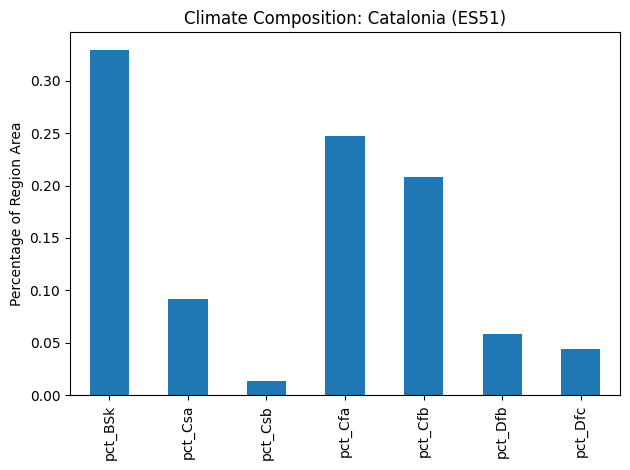

In [ ]:
example_region = final_gdf[final_gdf['NUTS_ID'] == 'ES51']  # Catalonia
if not example_region.empty:
    climate_cols = [c for c in example_region.columns if c.startswith('pct_')]
    climate_dist = example_region[climate_cols].iloc[0]
    climate_dist = climate_dist[climate_dist > 0.01]  # Only show >1%

    climate_dist.plot(kind='bar', title='Climate Composition: Catalonia (ES51)')
    plt.ylabel('Percentage of Region Area')
    plt.tight_layout()

    # plt.savefig('example_catalonia_climate.png', dpi=150)
    # print("\nValidation plot saved: example_catalonia_climate.png")

In [ ]:
final_gdf

,NUTS_ID,NUTS_NAME,CNTR_CODE,geometry,pct_BSk,pct_Csa,pct_Csb,pct_Cfa,pct_Cfb,pct_Dsb,...,pct_Af,pct_Am,pct_Aw,pct_BWk,pct_BWh,pct_BSh,pct_EF,pct_Dfa,pct_Dsa,pct_Cfc
0,FRL0,Provence-Alpes-Côte d’Azur,FR,"MULTIPOLYGON (((6.26057 45.12684, 6.2944 45.10...",0.038250,0.417245,0.148480,0.017108,0.117108,0.009314,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FRM0,Corse,FR,"MULTIPOLYGON (((9.46196 42.73465, 9.4534 42.66...",0.031872,0.579792,0.355869,0.000000,0.000000,0.019019,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FRY1,Guadeloupe,FR,"MULTIPOLYGON (((-61.01274 16.34362, -61.04196 ...",0.000000,0.000000,0.000000,0.000000,0.001015,0.000000,...,0.426687,0.494673,0.077626,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DEG0,Thüringen,DE,"POLYGON ((10.8115 51.63893, 10.82462 51.62696,...",0.001578,0.000000,0.000000,0.000000,0.602834,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DK01,Hovedstaden,DK,"MULTIPOLYGON (((15.11729 55.01314, 15.06971 54...",0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,PL63,Pomorskie,PL,"MULTIPOLYGON (((18.73194 54.37631, 18.88347 54...",0.000000,0.000000,0.000000,0.000000,0.113845,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,ITI2,Umbria,IT,"MULTIPOLYGON (((12.36458 43.61309, 12.36806 43...",0.001191,0.512506,0.003201,0.284502,0.181926,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,ITI3,Marche,IT,"POLYGON ((12.91128 43.91929, 13.15569 43.76129...",0.000000,0.000000,0.000000,0.817457,0.155728,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,ITI4,Lazio,IT,"MULTIPOLYGON (((11.84877 42.83795, 11.86903 42...",0.007661,0.755197,0.055632,0.047451,0.102897,0.001078,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
